# 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам в Classroom

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)
- [Композиции: бэггинг, случайный лес](https://habr.com/ru/company/ods/blog/324402/)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/winequality-red.csv.gz', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


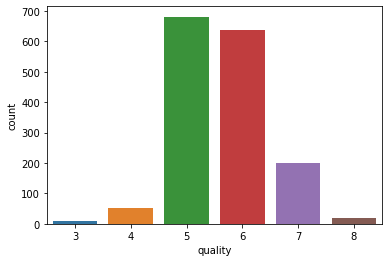

In [4]:
sns.countplot(df.quality)

Классы не сбалансированны. Низкого и высокго качества вин гораздо меньше "нормальных". Ну оно и в жизни так обосновано спросом.

In [5]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

In [6]:
X= df.drop(['quality'],axis=1)
y= df['quality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [9]:
def GridSearchModel(model, params, X, y, n_splits=5):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    search = GridSearchCV(model, params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    
    %time search.fit(X, y)
    model_name = '{}'.format(model).split('(')[0]
    print("{}\n\nBEST:\nmean_test_score={}\nparams={}".format(model_name,search.best_score_, search.best_params_))
    #return search

 - KNeighborsClassifier с 10 соседями

In [10]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,3,4]
         }
GridSearchModel(KNeighborsClassifier(), params, X=X_train, y=y_train)

CPU times: user 146 ms, sys: 9.93 ms, total: 156 ms
Wall time: 1.88 s
KNeighborsClassifier

BEST:
mean_test_score=0.506111714844599
params={'n_neighbors': 10, 'p': 1}


 - KNeighborsClassifier с 10 соседями и масштабированием StandartScaler

In [11]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

GridSearchModel(KNeighborsClassifier(), params, X=scaled_X_train, y=y_train)

CPU times: user 62.7 ms, sys: 0 ns, total: 62.7 ms
Wall time: 1.42 s
KNeighborsClassifier

BEST:
mean_test_score=0.58547707020213
params={'n_neighbors': 10, 'p': 2}


 - RidgeClassifier

In [12]:
params = {
            "alpha": np.arange(0,5,0.05),
            "normalize": [True,False]
         }
GridSearchModel(RidgeClassifier(), params, X=X_train, y=y_train)

CPU times: user 1.13 s, sys: 20 ms, total: 1.15 s
Wall time: 5.05 s
RidgeClassifier

BEST:
mean_test_score=0.5817778743751358
params={'alpha': 0.45, 'normalize': False}


 - DecisionTreeClassifier 

In [13]:
params = {
            "max_depth": np.linspace(1, 32, 20, endpoint=True),
            "min_samples_split": np.linspace(0.05, 1.0, 10, endpoint=True),
            "max_features": list(range(1,X_train.shape[1]))
         }
GridSearchModel(DecisionTreeClassifier(), params, X=X_train, y=y_train)

CPU times: user 8.78 s, sys: 81.5 ms, total: 8.86 s
Wall time: 24.8 s
DecisionTreeClassifier

BEST:
mean_test_score=0.6069289284938058
params={'max_depth': 12.421052631578947, 'max_features': 8, 'min_samples_split': 0.15555555555555556}


 - BaggingClassifier c 100 деревьев

In [14]:
params = {
            "n_estimators": [100],
            'max_samples' : [0.5, 0.6, 0.8, 1.0]
         }
GridSearchModel(BaggingClassifier(), params, X=X_train, y=y_train)

CPU times: user 563 ms, sys: 15.5 ms, total: 578 ms
Wall time: 5.55 s
BaggingClassifier

BEST:
mean_test_score=0.6667420126059552
params={'max_samples': 0.6, 'n_estimators': 100}


 - BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков.  

In [15]:
params = {
            "n_estimators": [100],
            'max_samples' : [0.5, 0.6, 0.8, 1.0],
            "max_features": [int(X_train.shape[1]/2)]    
         }
GridSearchModel(BaggingClassifier(), params, X=X_train, y=y_train)

CPU times: user 468 ms, sys: 3.92 ms, total: 472 ms
Wall time: 4.04 s
BaggingClassifier

BEST:
mean_test_score=0.6732840686807215
params={'max_features': 5, 'max_samples': 0.8, 'n_estimators': 100}


 - RandomForestClassifier c 100 деревьев

In [16]:
params = {
            "n_estimators": [100],
            "max_depth": np.linspace(1, 32, 20, endpoint=True),
            "max_features": [X_train.shape[1],int(X_train.shape[1]/2)] 
         }
GridSearchModel(RandomForestClassifier(), params, X=X_train, y=y_train)

CPU times: user 1.68 s, sys: 24.1 ms, total: 1.71 s
Wall time: 43.5 s
RandomForestClassifier

BEST:
mean_test_score=0.6704716366007389
params={'max_depth': 17.31578947368421, 'max_features': 5, 'n_estimators': 100}


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без  
     - Ответ: для метрических методов важно, чтобы все признаки имели одинковый масштаб, иначе признаки с меньшими значениями будут иметь меньший вес и могут быть проигнорированы.
- почему масштабирование не важно для деревьев решений
    - Ответ: деревья инвариантны к масштабу. Узел дерева разделяет данные на 2 набора только на основании одной функции, это разделение не зависит от других функций.
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
    - Ответ: по факту использовались все признаки, случайная половина признаков использовалось для обучения на каждом отдельном бутстрэпе, такие обученные модели потом были усреднены. Эффективность достигается за счет того, что отдельные модели получаются достаточно различными, но их ошибки компенсируются при голосовании. Усреднение ответов позволило уменьшить средний квадрат ошибки. 
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??
    - Ответ: наибольшее отклонени у knn без масштабирования, в этом случае не все признаки участвуют в предсказании (имеют достаточный вес), а при этом такие признаки могут быть достаточно важны. Необходимо применить масштабирование.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [17]:
from sklearn.datasets import load_digits

In [18]:
X, y = load_digits(return_X_y=True)
print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


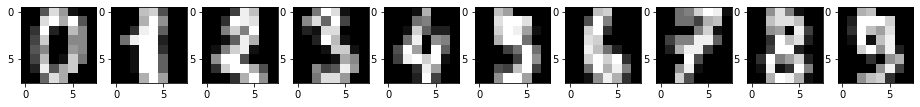

In [19]:
plt.figure(figsize=(16, 6))
width = int(np.sqrt(X.shape[1]))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i,:].reshape([width,width]), cmap='gray')

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

 - DecisionTreeClassifier с параметрами по-умолчанию

In [20]:
params = {

         }
GridSearchModel(DecisionTreeClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 49.3 ms, sys: 19.7 ms, total: 69 ms
Wall time: 213 ms
DecisionTreeClassifier

BEST:
mean_test_score=0.8519894475481069
params={}


 - BaggingClassifier с 100 деревьев  

In [21]:
params = {
            "n_estimators": [100]    
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 1.53 s, sys: 20 ms, total: 1.55 s
Wall time: 9.05 s
BaggingClassifier

BEST:
mean_test_score=0.9510273122284294
params={'n_estimators': 100}


 - BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев.

In [22]:
params = {
            "n_estimators": [100],
            "bootstrap_features": [True], # ??? #def False
            "bootstrap": [True], #def True
            "max_features": [8]
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 488 ms, sys: 3.93 ms, total: 492 ms
Wall time: 2.92 s
BaggingClassifier

BEST:
mean_test_score=0.9510397268777157
params={'bootstrap': True, 'bootstrap_features': True, 'max_features': 8, 'n_estimators': 100}


- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев

In [23]:
params = {
            "n_estimators": [100],
            "bootstrap_features": [False], #def False
            "bootstrap": [True], #def True
            "max_features": [8]
         }
GridSearchModel(BaggingClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 484 ms, sys: 12.1 ms, total: 496 ms
Wall time: 2.96 s
BaggingClassifier

BEST:
mean_test_score=0.9560614525139665
params={'bootstrap': True, 'bootstrap_features': False, 'max_features': 8, 'n_estimators': 100}


 - обычный случайный лес со 100 деревьями

In [24]:
params = {
            "n_estimators": [100],
            "max_depth": np.linspace(1, 32, 10, endpoint=True),
            "max_features": ["sqrt", 10,16,32,64]
         }
GridSearchModel(RandomForestClassifier(), params, X=X, y=y, n_splits=10)

CPU times: user 3.28 s, sys: 205 ms, total: 3.49 s
Wall time: 2min 47s
RandomForestClassifier

BEST:
mean_test_score=0.9794258224705151
params={'max_depth': 25.111111111111114, 'max_features': 'sqrt', 'n_estimators': 100}


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [25]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
params = {
            "n_estimators": [5,10,15,50,100,150,200,300]
         }
search = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    

%time search.fit(X, y)
pass

CPU times: user 1.03 s, sys: 12 ms, total: 1.04 s
Wall time: 18.9 s


In [26]:
print("BEST: mean_test_score={} params={}".format(search.best_score_, search.best_params_))

BEST: mean_test_score=0.9794165114835506 params={'n_estimators': 200}


In [27]:
estimators = list(search.cv_results_['param_n_estimators'])
scores = list(search.cv_results_['mean_test_score'])
best_x = search.best_params_['n_estimators']

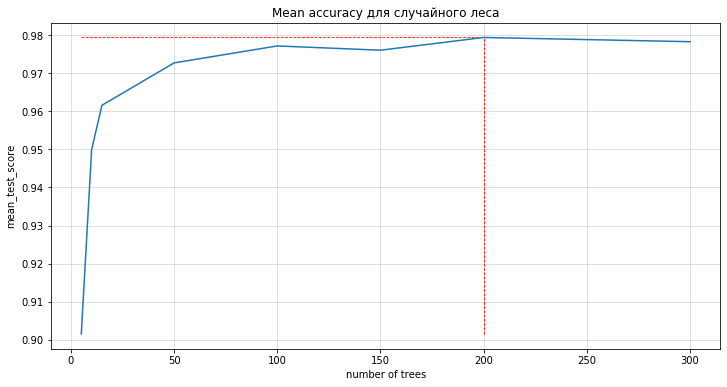

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Mean accuracy для случайного леса')
ax.set_xlabel('number of trees')
ax.set_ylabel('mean_test_score')
plt.plot([min(estimators),best_x],[max(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.plot([best_x,best_x],[min(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.grid(alpha=0.5)
sns.lineplot(x=estimators, y=scores)
plt.show()

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе выбирается случайное подмножество признаков, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле. Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

- max_depth - максимальная глубина дерева, по умолчанию максимальная глубина, когда все листы - это целевой признак. Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся.
- min_samples_leaf – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов. С данным параметром мы можем не выиграть в точности, но зато можем сильно уменьшить переобучение.
- min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла.
-  min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес
- max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения). Рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту.
- min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
- class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке. Может помочь если мультиклассовая классификация и есть дисбаланс
- max_features - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков). Рекомендуется в задачах классификации брать число фич для бутсртэпа как корень квадратный из числа фич выборки.

In [29]:
# Wall time: 44min 2s
if True==True:
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    params = {
            "n_estimators": [100],
            #"criterion":["gini", "entropy"],
            "max_depth":np.linspace(1, 200, 10) ,
            #"min_samples_split":[2,5,10],
            #"min_samples_leaf":[1,2,3,5],
            #"min_weight_fraction_leaf":[.0],
            "max_features":range(1,64,5),
            #"max_leaf_nodes":[None],
            #"min_impurity_decrease":[.0],
            #"min_impurity_split":[None],
            #"bootstrap":[True],
            "max_samples":[0.6,0.8,1],
            "class_weight":[None,"balanced","balanced_subsample"]           
             }
    search_all_params = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=-1,scoring='accuracy')                    

    %time search_all_params.fit(X, y)
    pass
    print("BEST: mean_test_score={}\nparams={}".format(search_all_params.best_score_, search_all_params.best_params_))

CPU times: user 1min 7s, sys: 4.62 s, total: 1min 12s
Wall time: 42min 3s
BEST: mean_test_score=0.9799627560521416
params={'class_weight': 'balanced', 'max_depth': 177.88888888888889, 'max_features': 11, 'max_samples': 0.8, 'n_estimators': 100}


In [46]:
scores = list(search_all_params.cv_results_['mean_test_score'])
best_x = np.argmax(scores)

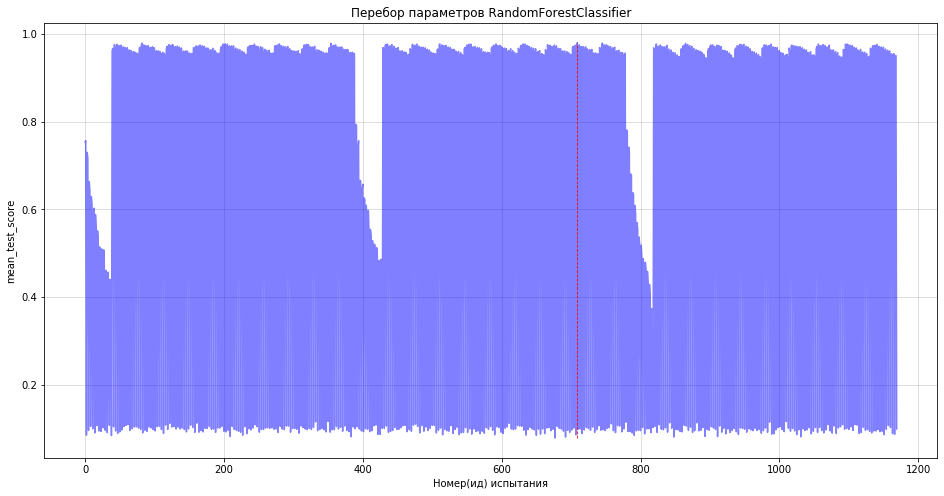

In [52]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Перебор параметров RandomForestClassifier')
ax.set_xlabel('Номер(ид) испытания')
ax.set_ylabel('mean_test_score')
plt.grid(alpha=0.5)
ax.plot(range(0,len(scores),1), scores, alpha=0.5, color='blue')
plt.plot([best_x,best_x],[min(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.show()

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

##### Ответы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?

In [30]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
params = {         
        "n_estimators": [10,50,100,200,500,1000,3000,5000]         
         }
search = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    
%time search.fit(X, y)
pass
print("BEST: mean_test_score={}\nparams={}".format(search.best_score_, search.best_params_))

CPU times: user 2.43 s, sys: 40.3 ms, total: 2.47 s
Wall time: 3min 30s
BEST: mean_test_score=0.9805338299193048
params={'n_estimators': 500}


In [31]:
estimators = list(search.cv_results_['param_n_estimators'])
scores = list(search.cv_results_['mean_test_score'])
best_x = search.best_params_['n_estimators']

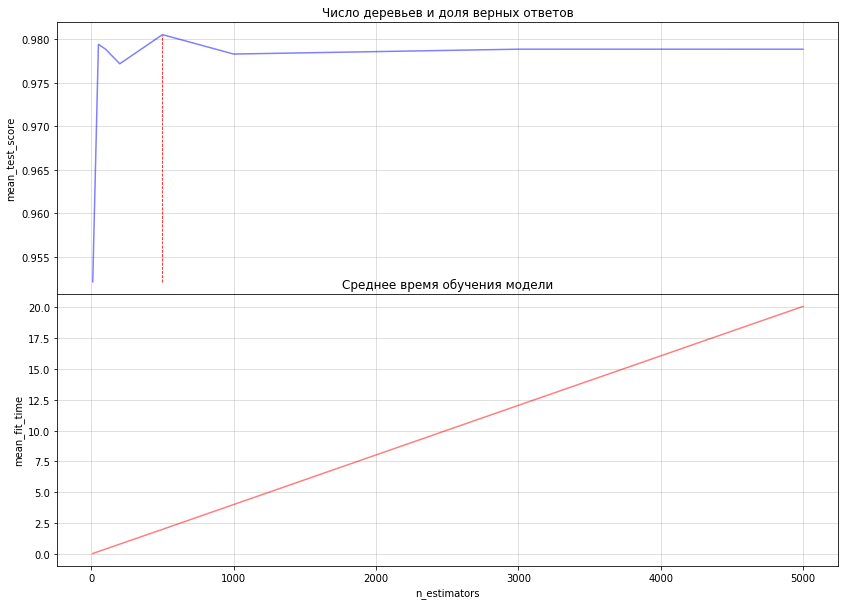

In [32]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.subplot(2,1,1)
plt.title('Число деревьев и доля верных ответов')
ax.set_xlabel('n_estimators')
ax.set_ylabel('mean_test_score')
ax.plot(estimators, scores, alpha=0.5, color='blue')
ax.plot([best_x,best_x],[min(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.grid(alpha=0.5)

ax2 = plt.subplot(2,1,2)
plt.title('Среднее время обучения модели')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('mean_fit_time')
ax2.plot(estimators, search.cv_results_['mean_fit_time'], alpha=0.5, color='red')
plt.grid(alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

При увеличении числа деревьев растет доля верных ответов, но при достижении определенного числа дальнейшего улучшения модели происходит не значительно или не происходит, а не тестовых данных улучшение может остановиться еще раньше. Чем больше деревьев, тем ,больше вычислительных затрат, но тем ниже шанс переобучения. Нужно выбирать оптимальное количество деревьев исходя из конкретной задачи.

- Как зависит качество предсказания в дереве в зависимости от max_features?

In [53]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
params = {         
        "max_features": range(1,X.shape[1],1)         
         }
search = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    
%time search.fit(X, y)
pass
print("BEST: mean_test_score={}\nparams={}".format(search.best_score_, search.best_params_))

CPU times: user 4.03 s, sys: 264 ms, total: 4.29 s
Wall time: 4min 38s
BEST: mean_test_score=0.9783054003724395
params={'max_features': 14}


In [54]:
features = list(search.cv_results_['param_max_features'])
scores = list(search.cv_results_['mean_test_score'])
best_x = search.best_params_['max_features']

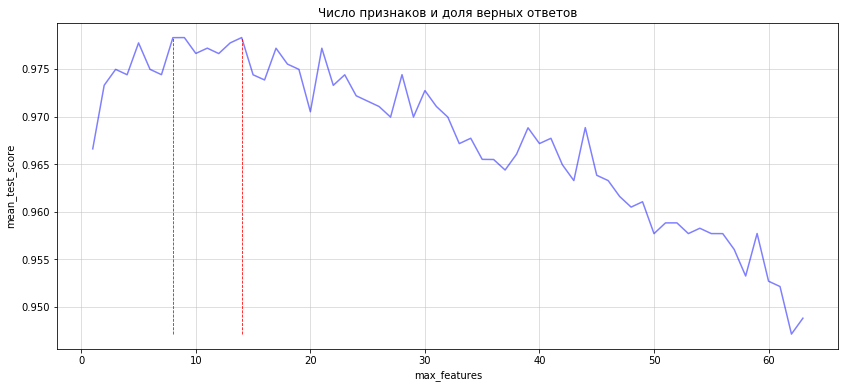

In [55]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.title('Число признаков и доля верных ответов')
ax.set_xlabel('max_features')
ax.set_ylabel('mean_test_score')
plt.grid(alpha=0.5)
ax.plot(features, scores, alpha=0.5, color='blue')
plt.plot([best_x,best_x],[min(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.plot([8,8],[min(scores),max(scores)],c='g',linestyle = '--',linewidth = 0.8)
plt.show()

При увеличении max_features увеличивается время построения леса, а деревья становятся «более однообразными», что приводит, в какой то момент, к ухудшению качества. По умолчанию max_features равен sqrt(n) в задачах классификации и n/3 в задачах регрессии. На практике значение 8(sqrt(n))(отмечено зеленым) достаточно приближено к лучшей оценке.

 - Почему качество зависит от max_features?

В задачах классификации рекомендуется брать число фич для бутсртэпа как корень квадратный из числа фич выборки, в этом и смысл бэггинга - итоговый ответ формируется на основе усреднения ответов "разных" деревьев, а отличия деревьев достигаются, в том числе, и ограниченными вних случайными наборами фич, так же добавить эффективность может исключение попадания выбросов в такие сэмплы, за счет использования не всех данных. Примеры ансамблей: «о жюри присяжных» или "мудрость толпы".

- Как глубина деревьев влияет на качество случайного леса?

In [36]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
params = {         
        "max_depth": np.linspace(1, 200, 100)        
         }
search = GridSearchCV(RandomForestClassifier(), params, cv=cv, verbose=0,n_jobs=2,scoring='accuracy')                    
%time search.fit(X, y)
pass
print("BEST: mean_test_score={}\nparams={}".format(search.best_score_, search.best_params_))

CPU times: user 6.17 s, sys: 427 ms, total: 6.6 s
Wall time: 3min 32s
BEST: mean_test_score=0.9816418373680944
params={'max_depth': 111.55555555555554}


In [37]:
depths = list(search.cv_results_['param_max_depth'])
scores = list(search.cv_results_['mean_test_score'])
best_x = search.best_params_['max_depth']

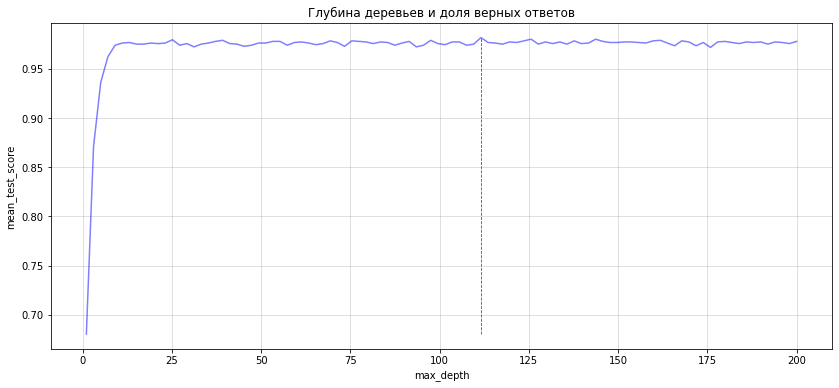

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.title('Глубина деревьев и доля верных ответов')
ax.set_xlabel('max_depth')
ax.set_ylabel('mean_test_score')
plt.grid(alpha=0.5)
ax.plot(depths, scores, alpha=0.5, color='blue')
plt.plot([best_x,best_x],[min(scores),max(scores)],c='r',linestyle = '--',linewidth = 0.8)
plt.show()

Увеличение глубины деревьев не самым лучшим образом сказывается на производительности, но повышает эффективность этого алгоритма (хотя и вместе с этим повышается склонность к переобучению). Слишком сильно бояться переобучения не следует, так как это будет скомпенсировано числом деревьев. Если объектов слишком много, то может быть дорого использовать максимальную глубину. Везде важны оптимально подобранные параметры (гиперпараметры).

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)